In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
import argparse
from pathlib import Path
from omegaconf import OmegaConf
from datetime import datetime
from torch_geometric.data import Data
import pandapower as pp
import networkx as nx
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

# sys.path.append(str(Path(__file__).parents[1]))
from scripts.arquitecturas import GNN_global, FCNN_global, GNN_Local
from scripts.Data_loader import load_net, load_data
from scripts.metric import NormalizedError
from scripts.train_eval import run_epoch, evaluate

from copy import deepcopy
import pandapower.plotting as plot
import os
import numba
import argparse

import julia
julia.install()

from julia.api import Julia
jl = Julia(compiled_modules=False)

import warnings
warnings.filterwarnings('ignore')

[ Info: Julia version info


Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
      "Manjaro Linux"
  uname: Linux 6.6.30-2-MANJARO #1 SMP PREEMPT_DYNAMIC Wed May  8 17:46:43 UTC 2024 x86_64 unknown
  CPU: 13th Gen Intel(R) Core(TM) i5-13400F: 
                 speed         user         nice          sys         idle          irq
       #1-16  3800 MHz    8395804 s      58270 s      84617 s    6998655 s      25561 s
       
  Memory: 62.63358688354492 GB (3337.64453125 MB free)
  Uptime: 97356.0 sec
  Load Avg:  8.2  8.45  8.74
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, goldmont)
Environment:
  HOME = /home/iboero
  PATH = /home/iboero/miniconda3/envs/proy/bin:/home/iboero/.vscode-server/bin/863d2581ecda6849923a2118d93a088b0745d9d6/bin/remote-cli:/home/iboero/miniconda3/envs/proy/bin:/home/iboero/miniconda3/condabin:/home/iboero/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/bin:/opt/cuda/bin:/opt/cuda/nsight_compute:/opt/cuda/n

[ Info: Julia executable: /home/iboero/julia/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /home/iboero/miniconda3/envs/proy/bin/python
│     libpython: /home/iboero/miniconda3/envs/proy/lib/libpython3.11.so.1.0
│ Python:
│     python: /home/iboero/miniconda3/envs/proy/bin/python
└     libpython: 


In [149]:
# Load q shunt model
dt = "best-05-21_22:21:19"
cfg = OmegaConf.load("./runs/uru/q_switch_shunt_opt/GNN_local/" + dt + "/config.yaml")
weights_dir = "./runs/uru/q_switch_shunt_opt/GNN_local/" + dt + "/weights/best_model.pt"

# Set device
torch.manual_seed(cfg.training.seed)
device = cfg.training.device

# Set network
num_nodes, num_gens, edge_index, edge_weights, feature_mask, net = load_net(cfg.data.red,cfg.data.red_path,cfg.data.target,device)

# Set model
if cfg.model.model == 'GNN_global':
    model_q_shunt = GNN_global(cfg.model.layers,edge_index,edge_weights,len(cfg.model.layers)-1,cfg.model.K,num_nodes,num_gens, feature_mask, cfg.model.batch_norm).to(device)
elif cfg.model.model == 'FCNN_global':
    # Add in and out dimension
    cfg.model.layers[0] *= num_nodes
    model_q_shunt = FCNN_global(cfg.model.layers,len(cfg.model.layers)-1,num_nodes, feature_mask, cfg.model.batch_norm).to(device)
elif cfg.model.model == 'GNN_local':
    model_q_shunt = GNN_Local(cfg.model.layers,edge_index,edge_weights,len(cfg.model.layers)-1,cfg.model.K,feature_mask,num_nodes,cfg.model.batch_norm).to(device)
elif cfg.model.model == 'FCNN_local':
    K = [0 for i in range(len(cfg.model.layers)-1)]
    model_q_shunt = GNN_Local(cfg.model.layers,edge_index,edge_weights,len(cfg.model.layers)-1,K,feature_mask,num_nodes,cfg.model.batch_norm).to(device)

# Cargo los pesos al modelo guardados en weights_dir +weights.pt
model_q_shunt.load_state_dict(torch.load(weights_dir))

# Load data
train_loader_q_shunt, val_loader_q_shunt, test_loader_q_shunt = load_data(cfg.data.data_path, cfg.training.batch_size, cfg.data.normalize_X, cfg.data.normalize_Y,cfg.data.target,device)

pandapowerNet-version is newer than your pandapower version. Please update pandapower `pip install --upgrade pandapower`.


edge_index tensor([[  0,   0,   1,   1,   2,   3,   4,   4,   5,   5,   5,   6,   6,   7,
           9,  10,  13,  13,  14,  14,  14,  14,  14,  15,  17,  17,  18,  18,
          20,  21,  22,  22,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  26,  26,  27,  27,  27,  28,  29,  31,  32,  32,  32,  33,  33,
          33,  33,  33,  34,  34,  34,  34,  35,  36,  37,  37,  37,  37,  38,
          40,  40,  40,  40,  40,  41,  41,  42,  48,  49,  49,  50,  50,  51,
          52,  52,  53,  53,  53,  55,  56,  58,  58,  58,  59,  62,  62,  65,
          65,  66,  66,  66,  66,  66,  67,  69,  70,  71,  71,  71,  72,  73,
          73,  74,  75,  75,  75,  75,  77,  77,  77,  78,  80,  81,  82,  82,
          83,  83,  88,  90,  90,  90,  90,  91,  91,  91,  92,  93,  94,  94,
          94,  94,  94,  96,   3,   3,   4,   5,   5,   8,   8,   9,   9,  10,
          11,  12,  95,  95,   2,   3,   4,   4,  11,  11,   7,   8,   9,   8,
          11,  11,  12,  12,  16,  19,  1

In [150]:
# Load vm pu model
dt = "best"
cfg = OmegaConf.load("./runs/uru/vm_pu_opt/GNN_local/" + dt + "/config.yaml")
weights_dir = "./runs/uru/vm_pu_opt/GNN_local/" + dt + "/weights/best_model.pt"

# Set device
torch.manual_seed(cfg.training.seed)
device = cfg.training.device

# Set network
num_nodes, num_gens, edge_index, edge_weights, feature_mask, net = load_net(cfg.data.red,cfg.data.red_path,cfg.data.target,device)

# Set model
if cfg.model.model == 'GNN_global':
    model_vm_pu = GNN_global(cfg.model.layers,edge_index,edge_weights,len(cfg.model.layers)-1,cfg.model.K,num_nodes,num_gens, feature_mask, cfg.model.batch_norm).to(device)
elif cfg.model.model == 'FCNN_global':
    # Add in and out dimension
    cfg.model.layers[0] *= num_nodes
    model_vm_pu = FCNN_global(cfg.model.layers,len(cfg.model.layers)-1,num_nodes, feature_mask, cfg.model.batch_norm).to(device)
elif cfg.model.model == 'GNN_local':
    model_vm_pu = GNN_Local(cfg.model.layers,edge_index,edge_weights,len(cfg.model.layers)-1,cfg.model.K,feature_mask,num_nodes,cfg.model.batch_norm).to(device)
elif cfg.model.model == 'FCNN_local':
    K = [0 for i in range(len(cfg.model.layers)-1)]
    model_vm_pu = GNN_Local(cfg.model.layers,edge_index,edge_weights,len(cfg.model.layers)-1,K,feature_mask,num_nodes,cfg.model.batch_norm).to(device)

# Cargo los pesos al modelo guardados en weights_dir +weights.pt
model_vm_pu.load_state_dict(torch.load(weights_dir))

# Load data
train_loader_vm_pu, val_loader_vm_pu, test_loader_vm_pu = load_data(cfg.data.data_path, cfg.training.batch_size, cfg.data.normalize_X, cfg.data.normalize_Y,cfg.data.target,device)

pandapowerNet-version is newer than your pandapower version. Please update pandapower `pip install --upgrade pandapower`.


edge_index tensor([[  0,   0,   1,   1,   2,   3,   4,   4,   5,   5,   5,   6,   6,   7,
           9,  10,  13,  13,  14,  14,  14,  14,  14,  15,  17,  17,  18,  18,
          20,  21,  22,  22,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  26,  26,  27,  27,  27,  28,  29,  31,  32,  32,  32,  33,  33,
          33,  33,  33,  34,  34,  34,  34,  35,  36,  37,  37,  37,  37,  38,
          40,  40,  40,  40,  40,  41,  41,  42,  48,  49,  49,  50,  50,  51,
          52,  52,  53,  53,  53,  55,  56,  58,  58,  58,  59,  62,  62,  65,
          65,  66,  66,  66,  66,  66,  67,  69,  70,  71,  71,  71,  72,  73,
          73,  74,  75,  75,  75,  75,  77,  77,  77,  78,  80,  81,  82,  82,
          83,  83,  88,  90,  90,  90,  90,  91,  91,  91,  92,  93,  94,  94,
          94,  94,  94,  96,   3,   3,   4,   5,   5,   8,   8,   9,   9,  10,
          11,  12,  95,  95,   2,   3,   4,   4,  11,  11,   7,   8,   9,   8,
          11,  11,  12,  12,  16,  19,  1

In [157]:

def combined_loader(loader1, loader2):
    for (x1, y1), (x2, y2) in zip(loader1, loader2):
        assert torch.equal(x1, x2), "Inputs x from both loaders must be the same"
        yield x1, y1, y2

# Create combined dataset
combined_data_loader = combined_loader(train_loader_q_shunt, train_loader_vm_pu)

# Iterate over the combined data loader
# for x, y1, y2 in combined_data_loader:
#     print(x.shape, y1.shape, y2.shape)
#     break

## Observamos la salida

In [7]:
x_0, y_0 = next(iter(train_loader))

# idx = 19

# x_0_i = x_0[idx].unsqueeze(0)
# y_0_i = y_0[idx].unsqueeze(0)
# net = pp.networks.case118()
net = pp.from_pickle(cfg.data.red_path)

pandapowerNet-version is newer than your pandapower version. Please update pandapower `pip install --upgrade pandapower`.


In [8]:
idxs_gen = np.where(y_0.detach().cpu()[0]!=0)[0]

In [6]:
y_0_pred = model(x_0).detach().cpu()

In [11]:
y_0_pred[0][idxs_gen]

tensor([[-59.3634],
        [-69.9771],
        [-39.3980],
        [  0.6485],
        [-60.9614]])

In [10]:
y_0[0][idxs_gen]

tensor([[-58.9832],
        [-70.0000],
        [-39.9998],
        [ -0.2578],
        [-59.9999]], device='cuda:0')

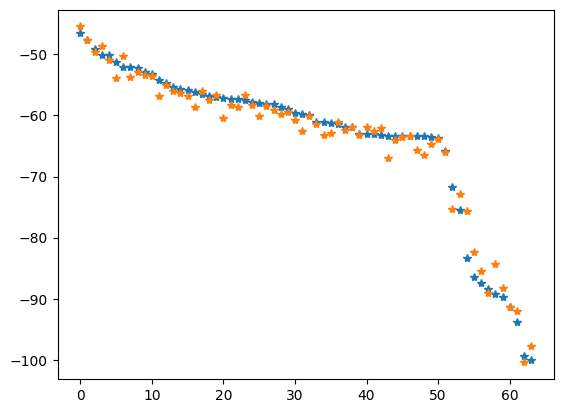

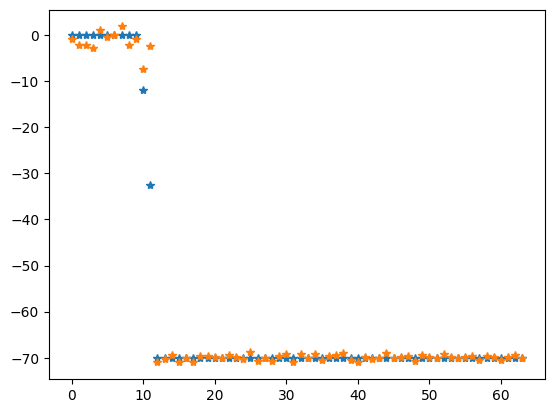

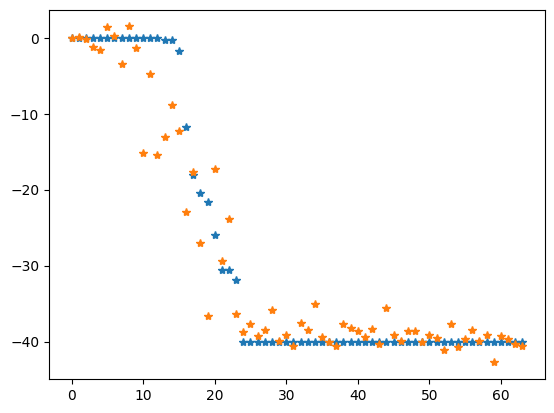

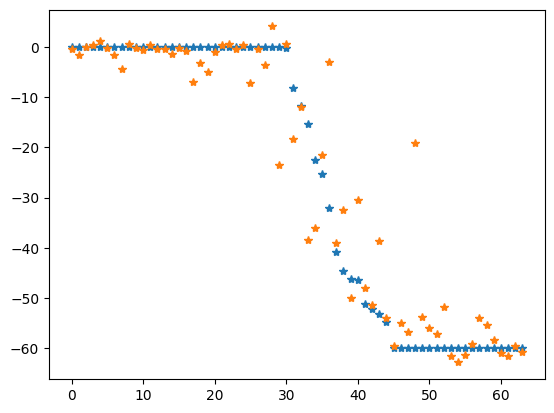

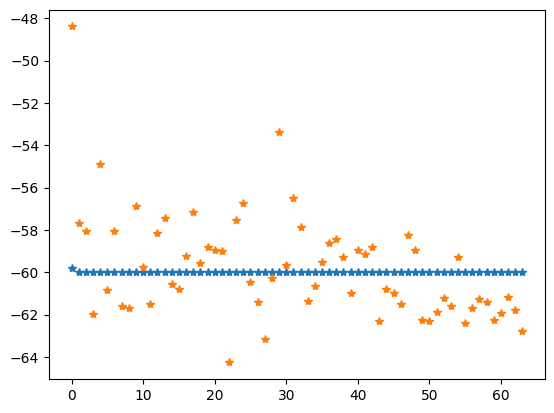

In [13]:
# Ordeno de mayor a menor y_0[:,0,0]
import matplotlib.pyplot as plt


for bus in idxs_gen:
    idx = torch.argsort(y_0[:,bus,0],descending=True).detach().cpu()
    y_0_ord = y_0[idx,bus,0].detach().cpu().numpy()
    y_0_pred_ord = y_0_pred[idx,bus,0].detach().cpu().numpy()

    plt.plot(y_0_ord,  "*")
    plt.plot(y_0_pred_ord, "*")
    # plt.ylim(0.9,1.1)
    plt.show()

In [5]:
# Concateno todos los datos de train loader
X_train = torch.cat([x for x, y in train_loader])
# Mismo para y
y_train = torch.cat([y for x, y in train_loader]).detach().cpu().numpy()
y_pred = model(X_train)

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.15 GiB. GPU 0 has a total capacity of 11.75 GiB of which 2.86 GiB is free. Process 72382 has 248.00 MiB memory in use. Including non-PyTorch memory, this process has 7.37 GiB memory in use. Process 73439 has 266.00 MiB memory in use. Of the allocated memory 5.84 GiB is allocated by PyTorch, and 1.40 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

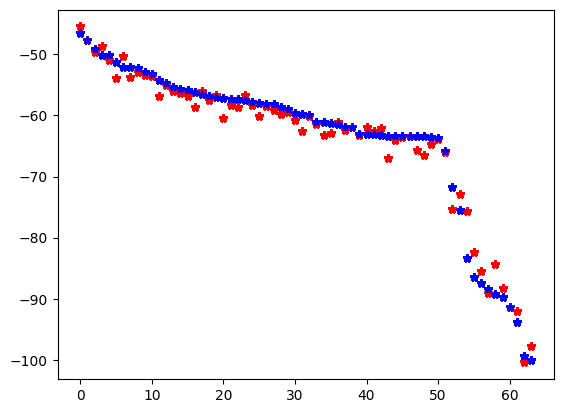

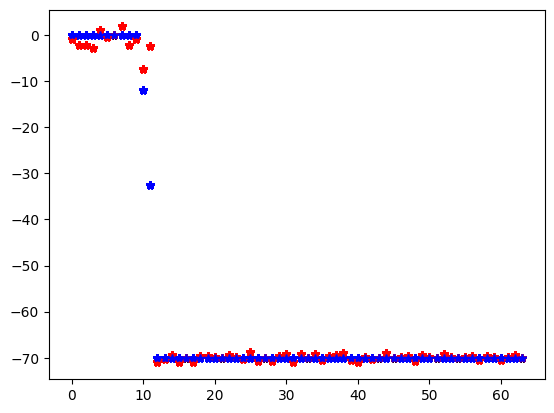

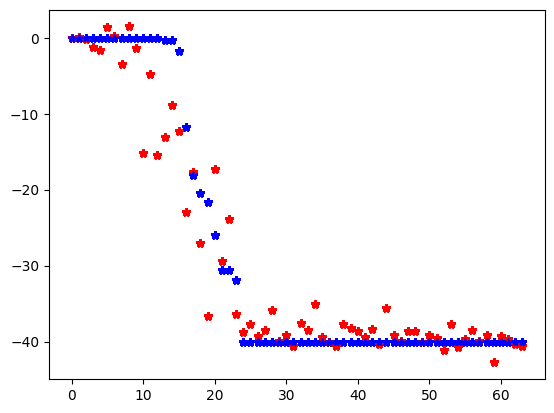

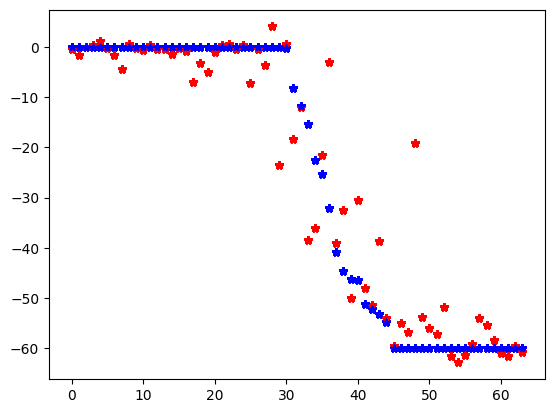

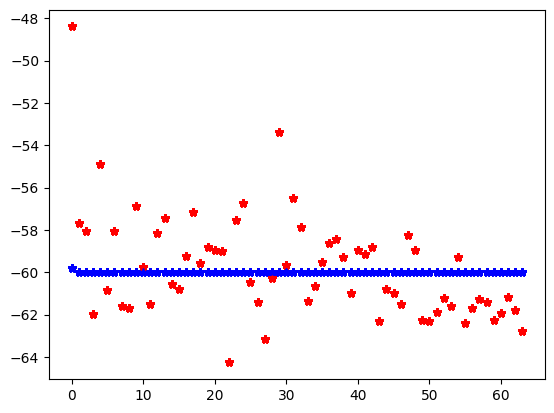

In [9]:
import matplotlib.pyplot as plt

for bus in idxs_gen:
    idx = torch.argsort(y_train[:,bus,0],descending=True).detach().cpu().numpy()
    y_train_ord = y_train[idx,bus,0].detach().cpu().numpy()
    y_pred_ord = y_pred[idx,bus,0].detach().cpu().numpy()

    plt.plot(y_pred_ord, "*")
    plt.plot(y_train_ord,  "*")
    # plt.ylim(0.9,1.1)
    plt.show()



## Nueva metrica de feasibility

In [158]:
idxs_gen = net.bus.index.get_indexer(list(net.gen.bus.values))
idxs_sgen = net.bus.index.get_indexer(net.sgen.bus.iloc[np.where(net.sgen.controllable==True)[0]])
idxs_load = net.bus.index.get_indexer(list(net.load.bus.values))

lineas_cargadas_count = 0
trafos_cargados_count = 0
min_q_count = 0
max_q_count = 0
min_vmpu_count = 0
max_vmpu_count = 0

len_data_loader = 0
for j, data in enumerate(combined_data_loader):
    x_0, y_0_shunt, y_0_vmpu = data
    y_0_shunt_pred = model_q_shunt(x_0).detach().cpu()
    y_0_vmpu_pred = model_vm_pu(x_0).detach().cpu()
    # get list of num random numbers between 0 and batch_size
    batch_size = x_0.shape[0]
    num = 5
    idxs = torch.randint(0, batch_size, (num,))
    len_data_loader += 1
    for i in idxs:
        net.gen.vm_pu = y_0_vmpu_pred[i][idxs_gen].detach().cpu().numpy()
        net.sgen.loc[net.sgen.controllable==True].q_mvar = y_0_shunt_pred[i][idxs_sgen].detach().cpu().numpy()
        net.load.p_mw = x_0[i,idxs_load,0].detach().cpu().numpy()
        net.load.q_mvar = x_0[i,idxs_load,1].detach().cpu().numpy()
        net.gen.p_mw = x_0[i,idxs_gen,2].detach().cpu().numpy()
        pp.runpp(net,numba=False)

        lineas_cargadas_count += (net.res_line.loading_percent>100).sum()/num
        trafos_cargados_count += (net.res_trafo.loading_percent>100).sum()/num
        min_q_count += (net.res_gen.q_mvar<net.gen.min_q_mvar).sum()/num
        max_q_count += (net.res_gen.q_mvar>net.gen.max_q_mvar).sum()/num
        min_vmpu_count += (net.res_bus.vm_pu<net.bus.min_vm_pu).sum()/num
        max_vmpu_count += (net.res_bus.vm_pu>net.bus.max_vm_pu).sum()/num

print(f"Lineas cargadas promedio total: {lineas_cargadas_count/len_data_loader}")
print(f"Transformadores cargados promedio total: {trafos_cargados_count/len_data_loader}")
print(f"Menores a Min GenQ promedio total: {min_q_count/len_data_loader}")
print(f"Mayores a Max GenQ promedio total: {max_q_count/len_data_loader}")
print(f"Menores a Min Vpu promedio total: {min_vmpu_count/len_data_loader}")
print(f"Mayores a Max Vpu promedio total: {max_vmpu_count/len_data_loader}")

Lineas cargadas promedio total: 0.16438356164383555
Transformadores cargados promedio total: 0.0
Menores a Min GenQ promedio total: 4.82648401826484
Mayores a Max GenQ promedio total: 1.3890410958903976
Menores a Min Vpu promedio total: 0.44018264840182697
Mayores a Max Vpu promedio total: 0.005479452054794521
